In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

In [2]:
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
import os
import sys

if os.path.abspath('../../..') not in sys.path:
    sys.path.append(os.path.abspath('../../..'))

In [4]:
import json
import re
import logging

from collections import defaultdict

import tqdm

import numpy as np
import pandas as pd

from flashtext import KeywordProcessor

from gensim.parsing.preprocessing import (
    preprocess_string, 
    strip_tags,
    strip_punctuation, 
    strip_multiple_whitespaces, 
    strip_numeric, 
    lower_to_unicode,
    strip_short,
    remove_stopwords,
)
from gensim.corpora.dictionary import Dictionary
from gensim.models import AuthorTopicModel as GensimAuthorTopicModel
from gensim.test.utils import temporary_file
from gensim.models.callbacks import CoherenceMetric, DiffMetric, PerplexityMetric, ConvergenceMetric

from src.dataset import load_tweets, load_availability
from src.config import config

In [5]:
logging.basicConfig(
    format='%(asctime)s:%(levelname)s:%(message)s', 
    level=logging.WARNING,
    handlers=[
        logging.StreamHandler(),
    ]
)

In [6]:
def load_keywords(path=None):
    if path is None:
        path = '../../../data/external/keywords.v3.2.csv'
    df = pd.read_csv(path)
    output = defaultdict(set)
    for row in df.itertuples():
        phrase, topic = row.raw_keyword, row.label
        for token in phrase.split(' '):
            if len(token) > 2:
                output[topic].add(token)
    return {k: list(v) for k, v in output.items()}

keywords = load_keywords()

In [7]:
keyword_processor = KeywordProcessor()

keyword_processor.add_keywords_from_dict(keywords)

In [8]:
url_pattern = re.compile('\Bhttp[s]?://\S+')
hashtag_pattern = re.compile('\B\#[a-zA-Z0-9_]+')
mention_pattern = re.compile('\B\@[a-zA-Z0-9_]+')

In [9]:
class Document:
    def __init__(self, text, author=None):
        self.text = text
        self.author = author
        self.tokens = None
        
    def set_tokens(self, tokens):
        self.tokens = tokens
        return self
    
def load_documents(path=None):
    if path is None:
        path = '../../../data/interim/models/tweets_intra_subject_analysis.jsonl'
    with open(path, 'r') as fp:
        for line in tqdm.tqdm(fp.readlines(), desc='Loading Documents'):
            record = json.loads(line)
            text = record['tweet']['text']
            author = record['subject_id']
            d = Document(text=text, author=author)
            yield d

In [10]:
results = []

for doc in load_documents():
    keywords_found = keyword_processor.extract_keywords(doc.text)
    if len(keywords_found) == 0:
        continue
    hashtags = hashtag_pattern.findall(doc.text)
    tokens = preprocess_string(doc.text, filters=[
        lower_to_unicode,
        lambda x: url_pattern.sub(' ', x),
        lambda x: hashtag_pattern.sub(' ', x),
        lambda x: mention_pattern.sub(' ', x),
        strip_tags,
        strip_punctuation,
        strip_numeric,
        lambda x: x + ' '.join(hashtags),
        remove_stopwords,
        strip_short,
        strip_multiple_whitespaces, 
    ])
    doc.set_tokens(tokens)
    if len(doc.tokens) > 5:
        results.append(doc)

Loading Documents: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 820202/820202 [02:16<00:00, 6013.26it/s]


In [11]:
tokenized_docs = []
for i, doc in enumerate(tqdm.tqdm(results, desc='Extracting Tokens')):
    tokenized_docs.append(doc.tokens)

author2doc = defaultdict(list)
for i, doc in enumerate(tqdm.tqdm(results, desc='Extracting Author Docs')):
    author2doc[doc.author].append(i)
author2doc = dict(author2doc)
        
dictionary = Dictionary(tokenized_docs)

corpus = [dictionary.doc2bow(tokenized_doc) for tokenized_doc in tqdm.tqdm(tokenized_docs)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 452347/452347 [00:08<00:00, 55519.05it/s]


In [12]:
def create_eta(keywords, vocab, num_topics, pseudo_count=1e7, normalize=True):
    # create a (ntopics, nterms) matrix and fill with 1
    eta = np.full(shape=(num_topics, len(vocab)), fill_value=1)
    # for each topic in the seed dict
    topic2id = {topic: i for i, topic in enumerate(keywords)}
    # for each topic in the seed dict
    for topic, tokens in keywords.items(): 
        # for each seed token that is in vocab
        for token in tokens:
            if token in vocab.token2id:
                eta[topic2id[topic], vocab.token2id[token]] = pseudo_count
    if normalize:
        eta = np.divide(eta, eta.sum(axis=0))
    return eta

eta = create_eta(keywords, dictionary, len(keywords) + 1, len(corpus) // 100, normalize=True)

eta.shape

(6, 427395)

In [13]:
try:
    model = GensimAuthorTopicModel.load('../../../data/interim/models/models/v2.pt')
except FileNotFoundError as ex:
    # Set training parameters.
    kwargs = {
        'passes': 20,
        'iterations': 400,
        'chunksize': 2000,
    }
    with temporary_file('serialized') as s_path:
        model = GensimAuthorTopicModel(
            corpus,
            author2doc=author2doc, 
            chunksize=kwargs.get('chunksize', 1000),
            passes=kwargs.get('passes', 1),
            iterations=kwargs.get('iterations', 50),
            id2word=dictionary, 
            num_topics=eta.shape[0],
            eta=eta,
            serialized=True, 
            serialization_path=s_path,
            eval_every=None,
        )
        model.save('../../../data/interim/models/models/v2.pt')

In [14]:
author_vecs = [model.get_author_topics(author) for author in model.id2author.values()]

In [15]:
# Train the model on the corpus.
for topic_id in range(model.num_topics):
    for term_id, p in model.get_topic_terms(topic_id):
        print('{:>02} {:<30s}{:0.3f}'.format(topic_id, dictionary[term_id], p))

00 climate                       0.010
00 story                         0.010
00 change                        0.006
00 black                         0.005
00 million                       0.004
00 proactive                     0.003
00 students                      0.003
00 stories                       0.003
00 important                     0.003
00 deaths                        0.003
01 https                         0.062
01 new                           0.009
01 amp                           0.007
01 storm                         0.007
01 people                        0.006
01 today                         0.006
01 like                          0.006
01 time                          0.005
01 florida                       0.005
01 tropical                      0.005
02 community                     0.012
02 journalists                   0.009
02 environmental                 0.008
02 energy                        0.008
02 based                         0.007
02 global                

In [16]:
tropic_proba = []

for i in tqdm.tqdm(range(len(results))):
    tropic_proba.append(list(zip(*model.get_new_author_topics(corpus[i:i+1])))[1])
    
tropic_proba = np.array(tropic_proba)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 452347/452347 [02:20<00:00, 3210.64it/s]


In [17]:
np.unique(tropic_proba.argmax(axis=1), return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([ 50308, 394703,   3938,    306,   2202,    890]))

In [21]:
from sklearn.manifold import TSNE

import seaborn as sns
from src.plotting import bokeh as bhp

sns.set_theme()
bhp.output_notebook()

Loading BokehJS ...

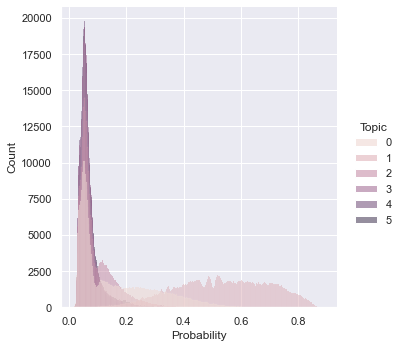

In [19]:
fig_data = [{'Topic': i, 'Probability': p} for i in range(tropic_proba.shape[1]) for p in tropic_proba[:, i]]

fig_df = pd.DataFrame(fig_data)

sns.displot(fig_df, x='Probability', hue='Topic')

In [22]:
%%time
tsne = TSNE(n_components=2, random_state=0)
smallest_author = 0  # Ignore authors with documents less than this.
authors = [model.author2id[a] for a in model.author2id.keys() if len(model.author2doc[a]) >= smallest_author]
_ = tsne.fit_transform(model.state.gamma[authors, :])  # Result stored in tsne.embedding_

x = tsne.embedding_[:, 0]
y = tsne.embedding_[:, 1]
author_names = [model.id2author[a] for a in authors]

# Radius of each point corresponds to the number of documents attributed to that author.
scale = 0.1
author_sizes = [len(model.author2doc[a]) for a in author_names]
radii = [size * scale for size in author_sizes]

source = bhp.ColumnDataSource(
    data=dict(
        x=x,
        y=y,
        author_names=author_names,
        author_sizes=author_sizes,
        radii=radii,
    )
)

# Add author names and sizes to mouse-over info.
hover = bhp.HoverTool(
    tooltips=[
        ("author", "@author_names"),
        ("size", "@author_sizes"),
    ]
)

p = bhp.figure(tools=[hover, 'crosshair,pan,wheel_zoom,box_zoom,reset,save,lasso_select'])
p.scatter('x', 'y', radius='radii', source=source, fill_alpha=0.6, line_color=None)
bhp.show(p)

/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 7.7 s, sys: 279 ms, total: 7.98 s
Wall time: 7.94 s
